# Example compressed Planck likelihood

In this notebok we run the compressed Planck likelihood presented in Reeves et al. () and compare the derived contours in LCDM with the official Planck chains and the uncompressed likelihood. We make use of the likelihoods and emcee set-up written in "run_mcmc_with_emulator.py" which is based on functions from the ChaosHammer package (see https://arxiv.org/abs/2207.01627)

In [1]:
#Install trianglechain package for plotting contours if you do not already have it
!pip install trianglechain
#Install cosmopower package for the emulator part of this notebook if you don't already have it- see description later
!pip install cosmopower

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import FortranFile
from trianglechain import TriangleChain

In [3]:
filename_config = "./data/configs/config_full_lensing_plus_cmb.yaml" #config file for running the sampler
survey_path = "./data"

## Preliminary steps 

Here we download everything we need to run the Planck likelihoods: binning files, covariance matrices and data vectors

In [4]:
#CMB lensing.

#These are the pieces for the "CMB marginalized Planck2018" lensing likelihood. See description in our paper.

bin_matrix_file = survey_path + '/planck18_lensing_data/binning_plus_correction_matrix.txt'
covariance_file = survey_path + '/planck18_lensing_data/covariance.txt'
offset_file = survey_path + '/planck18_lensing_data/theory_offset.txt'
cl_hat_file = survey_path + '/planck18_lensing_data/cl_hat.txt'

bin_matrix=np.loadtxt(bin_matrix_file)
covariance=np.loadtxt(covariance_file)
corr_lens=np.loadtxt(offset_file)
cl_hat=np.loadtxt(cl_hat_file)

covariance_cmblens = covariance.reshape(9,-1)
bin_matrix_cmblens = bin_matrix.reshape(9,-1)

inv_c_lens = np.linalg.inv(covariance_cmblens) #only used if not doing xcorrs

lens_data = [inv_c_lens, cl_hat, bin_matrix_cmblens, corr_lens]

In [5]:
#CMB primary

#These are the pieces required for the CMB plik-lite implementation that is based on the publicly available python implementation: https://github.com/heatherprince/planck-lite-py
def load_covmat(cov_file, nbin):
    #Function to load covmat from Fortran format
    f = FortranFile(cov_file, 'r')
    covmat = f.read_reals(dtype=float).reshape((nbin,nbin))
    for i in range(nbin):
        for j in range(i,nbin):
            covmat[i,j] = covmat[j,i]

    return covmat

blmin_file = survey_path + '/cmb/blmin.dat' 
blmax_file = survey_path + '/cmb/blmax.dat'
binw_file = survey_path + '/cmb/bweight.dat'

blmin=np.loadtxt(blmin_file).astype(int)
blmax=np.loadtxt(blmax_file).astype(int)
binw=np.loadtxt(binw_file)

cov_cmb = load_covmat(survey_path + '/cmb/c_matrix_plik_v22.dat', 613) #613 bins for full TT/TE/EE
inv_cov_cmb = np.linalg.inv(cov_cmb)

bval, cl_obs_cmb, X_sig = np.genfromtxt(survey_path + '/cmb/cl_cmb_plik_v22.dat', unpack=True) #data vector

#Now for the low-ell part of the likelihood based on https://github.com/heatherprince/planck-low-py
#EE
data_dir_lowl = './data/data_lowl'
lmin_list_EE, lmax_list_EE, mu_LN_EE, sig_LN_EE, loc_LN_EE=np.loadtxt(data_dir_lowl +
        '/lognormal_fit_'+'3'+'bins_EE.txt', unpack=True)

#TT
lmin_list_TT, lmax_list_TT, mu_LN_TT, sig_LN_TT=np.loadtxt(data_dir_lowl + 
        '/lognormal_fit_'+'2'+'bins_TT.txt', unpack=True)

data_lowl = [lmin_list_EE, lmax_list_EE, mu_LN_EE, sig_LN_EE, loc_LN_EE, lmin_list_TT, lmax_list_TT, mu_LN_TT, sig_LN_TT]
lognorm_list = [['ee',data_lowl],['tt',data_lowl]]

## Import the emulators 

Now we have all of the data required to compute the respective CMB primary and CMB lesning likelihoods lets import our eneural network models to speed up sampling 

In [6]:
#here we use models trained using the cosmopower framework (see https://arxiv.org/abs/2106.03846 and https://github.com/alessiospuriomancini/cosmopower)
#Hence we must import this using their module 

import cosmopower as cp 

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename='./data/emulator_models/TT_model'
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename='./data/emulator_models/TE_model'
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename='./data/emulator_models/EE_model'
                                )

kk_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename='./data/emulator_models/CMB_KK_model')

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [7]:
#Here we actually run the chains
from run_mcmc_with_emulator import (
    run_mcmc_with_emulator,
)
params_chain, lnprobs = run_mcmc_with_emulator(
    # n_samples=7e5,
    n_samples=3e5,
    cl_obs=None,
    C=None,
    lims=None,
    emu_lss_list = None,
    emu_cmb_list = [tt_emu_model, te_emu_model, ee_emu_model],
    emu_cmb_lensing_list=[kk_emu_model],
    filename_config=filename_config,

    #Set up gaussian prior for the A_planck parameter
    gaussian_priors=[6],
    gauss_mean = [1],
    gauss_sigma = [0.0025],

    cosmology_params_fixed={'m_nu':0.02,'A_lens':1.0}, #Fix neutrino mass and Alens  as we just want LCDM
    compression_vectors_list=None,


    #Pass in all of the likelihood data to be handled by run_mcmc_with_emulator
    lens_data = lens_data,
    lognorm_list=lognorm_list,

    inv_C_cmb = inv_cov_cmb,
    dv_cmb = cl_obs_cmb,
    bl_min_cmb = blmin,
    bl_max_cmb = blmax,
    binw_cmb = binw,
    cmb_experiment='planck',
    nuisance_params = True)

params_chain_burned_in = params_chain[100000:]

COSMO PARAMS FIXED: ['m_nu', 'A_lens']
VAR: ['omega_cdm' 'omega_b' 'sigma8' 'tau' 'n_s' 'h' 'A_planck']
23-09-19 01:00:59 run_mcmc_w INF   MCMC starting point defined 
23-09-19 01:00:59 run_mcmc_w INF   setting prior from config for param: tau 


100%|██████████| 586/586 [01:58<00:00,  4.97it/s]


## Lets compare with the official chains

In [9]:
#Download chains 
!wget "https://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00.zip" -O "planck_chains.zip"

import zipfile
import os 

with zipfile.ZipFile("planck_chains.zip", 'r') as zip_ref:
    zip_ref.extractall('data/planck_chains')


os.remove("planck_chains.zip")

--2023-09-19 01:02:59--  https://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00.zip
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/zip]
Saving to: ‘planck_chains.zip’

planck_chains.zip       [   <=>              ]  62,33M  13,5MB/s    in 7,4s    

2023-09-19 01:03:06 (8,39 MB/s) - ‘planck_chains.zip’ saved [65362284]



In [10]:
for i in range(1,5): 
    planck_chain_raw = np.loadtxt(f'./data/planck_chains/base/plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing_{i}.txt')
    # planck_chain_raw = np.loadtxt(f'/Users/alexreeves/Desktop/planck_lensing_2018/COM_CosmoParams_lensonly_R3.01/base/lensing_lenspriors/base_lensing_lenspriors_post_ptt_{i}.txt')

    if i ==1:
        planck_chain_tot = planck_chain_raw

    else:
        planck_chain_tot = np.vstack((planck_chain_tot, planck_chain_raw))

In [11]:
#This is just a helper function to put the chains in the right format for the trainglechain plotting 

def transform_planck_raw_to_paramchain(data, names, indices):

    if data.dtype.names is not None:
        return data

    else:
        n_rows, n_cols = data.shape[0], len(names)
        print('rows', n_rows)
        dtype = np.dtype(
            dict(
                formats=[data.dtype] * n_cols,
                names=[f"{names[i]}" for i in range(n_cols)],
            )
        )
        rec = np.empty(n_rows, dtype=dtype)
        for i in range(n_cols):
            if names[i] == 'h':
                #convert from H0 to h 
                rec[names[i]] = data[:, indices[i]]/100
            else:
                rec[names[i]] = data[:, indices[i]]
        return rec

#The parameters we want to plot 
names = ['omega_b','omega_cdm', 'h','sigma8','n_s', 'tau']
indices = [2,3,29,35,7,5]
params=names
planck_official = transform_planck_raw_to_paramchain(planck_chain_tot, names, indices)

rows 25225


## Now lets make a compressed version of the likelihood

In [12]:
compression_vectors_cmb_primary  = np.load("./data/moped_compression_vecs/cmb_primary/moped_compression_vectors_paramshsigma8omega_cdmtaunsomega_b.npy")
compression_vectors_cmb_lensing = np.load("./data/moped_compression_vecs/cmb_lensing/moped_compression_vectors_paramshsigma8omega_bomega_mns.npy") #parameter list in name is the order of the compression vectors in array


In [13]:
dv_moped_cmb = np.dot(cl_obs_cmb, compression_vectors_cmb_primary)
cov_moped_cmb = np.identity(6) # the size cosmological params including tau 

dv_moped_kk = np.dot(cl_hat, compression_vectors_cmb_lensing)
cov_moped_kk = np.identity(5) # the size cosmological params not including tau 


In [14]:
#Updating the lens_data to the MOPED compressed version
lens_data = [cov_moped_kk, dv_moped_kk, bin_matrix_cmblens, corr_lens] #create a list with the data required to compute the CMB lensing likelihood

In [15]:
from run_mcmc_with_emulator import (
    run_mcmc_with_emulator,
)
params_chain_moped, lnprobs = run_mcmc_with_emulator(
    n_samples=7e5,
    cl_obs=None,
    C=None,
    lims=None,
    emu_lss_list = None,
    emu_cmb_list = [tt_emu_model, te_emu_model, ee_emu_model],
    emu_cmb_lensing_list=[kk_emu_model],
    filename_config=filename_config,
    # gaussian_priors=[1,3],
    # gauss_mean = [0.0222, 0.96],
    # gauss_sigma = [0.0005, 0.02],
    gaussian_priors=[6],
    gauss_mean = [1],
    gauss_sigma = [0.0025],

    cosmology_params_fixed={'m_nu':0.02,'A_lens':1.0},
    compression_vectors_list=None,
    lens_data = lens_data,
    lognorm_list=lognorm_list,

    inv_C_cmb = cov_moped_cmb, #identity is its own inverse!
    dv_cmb = dv_moped_cmb,
    bl_min_cmb = blmin,
    bl_max_cmb = blmax,
    binw_cmb = binw,
    cmb_experiment='planck',
    compression_vectors_list_cmb = [compression_vectors_cmb_primary],
    compression_vectors_list_lensing = [compression_vectors_cmb_lensing],

    nuisance_params = True)

params_chain_moped_burned_in = params_chain_moped[400000:]

COSMO PARAMS FIXED: ['m_nu', 'A_lens']
VAR: ['omega_cdm' 'omega_b' 'sigma8' 'tau' 'n_s' 'h' 'A_planck']
23-09-19 01:03:08 run_mcmc_w INF   MCMC starting point defined 
23-09-19 01:03:08 run_mcmc_w INF   setting prior from config for param: tau 


100%|██████████| 1368/1368 [05:42<00:00,  3.99it/s]


In [16]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['legend.shadow'] = False
matplotlib.rcParams['legend.frameon'] = False

In [17]:
#parameter ranges for the plotting 
ranges = {
    'omega_m': [0.28,0.36],
    'sigma8': [0.78,0.84],
    'omega_b': [0.0218, 0.023],
    'del_z1': [-0.03, 0.04],
    'del_z2': [-0.03, 0.04],
    'del_z3': [-0.03, 0.04],
    'del_z4': [-0.03, 0.04],
    'del_z5': [-0.03, 0.04],
    'tau':[0.02, 0.08],
    'A_IA':[-0.5,1.5],
    'bias_l1':[1.6,2],
    'bias_c2':[1.9,2.2],
    'S8':[0.7,0.9],
    'omega_cdm':[0.112,0.13],
    'n_s': [0.95,0.98],
    'h':[0.65,0.7],
    'A_planck': [0.99,1.01],}

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(<Figure size 2400x2400 with 36 Axes>,
 array([[<Axes: ylabel='$\\omega_b$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\omega_{cdm}$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='h'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='$\\sigma_8$'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$n_s$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='$\\omega_b$', ylabel='$\\tau_{reio}$'>,
         <Axes: xlabel='$\\omega_{cdm}$'>, <Axes: xlabel='h'>,
         <Axes: xlabel='$\\sigma_8$'>, <Axes: xlabel='$n_s$'>,
         <Axes: xlabel='$\\tau_{reio}$'>]], dtype=object))

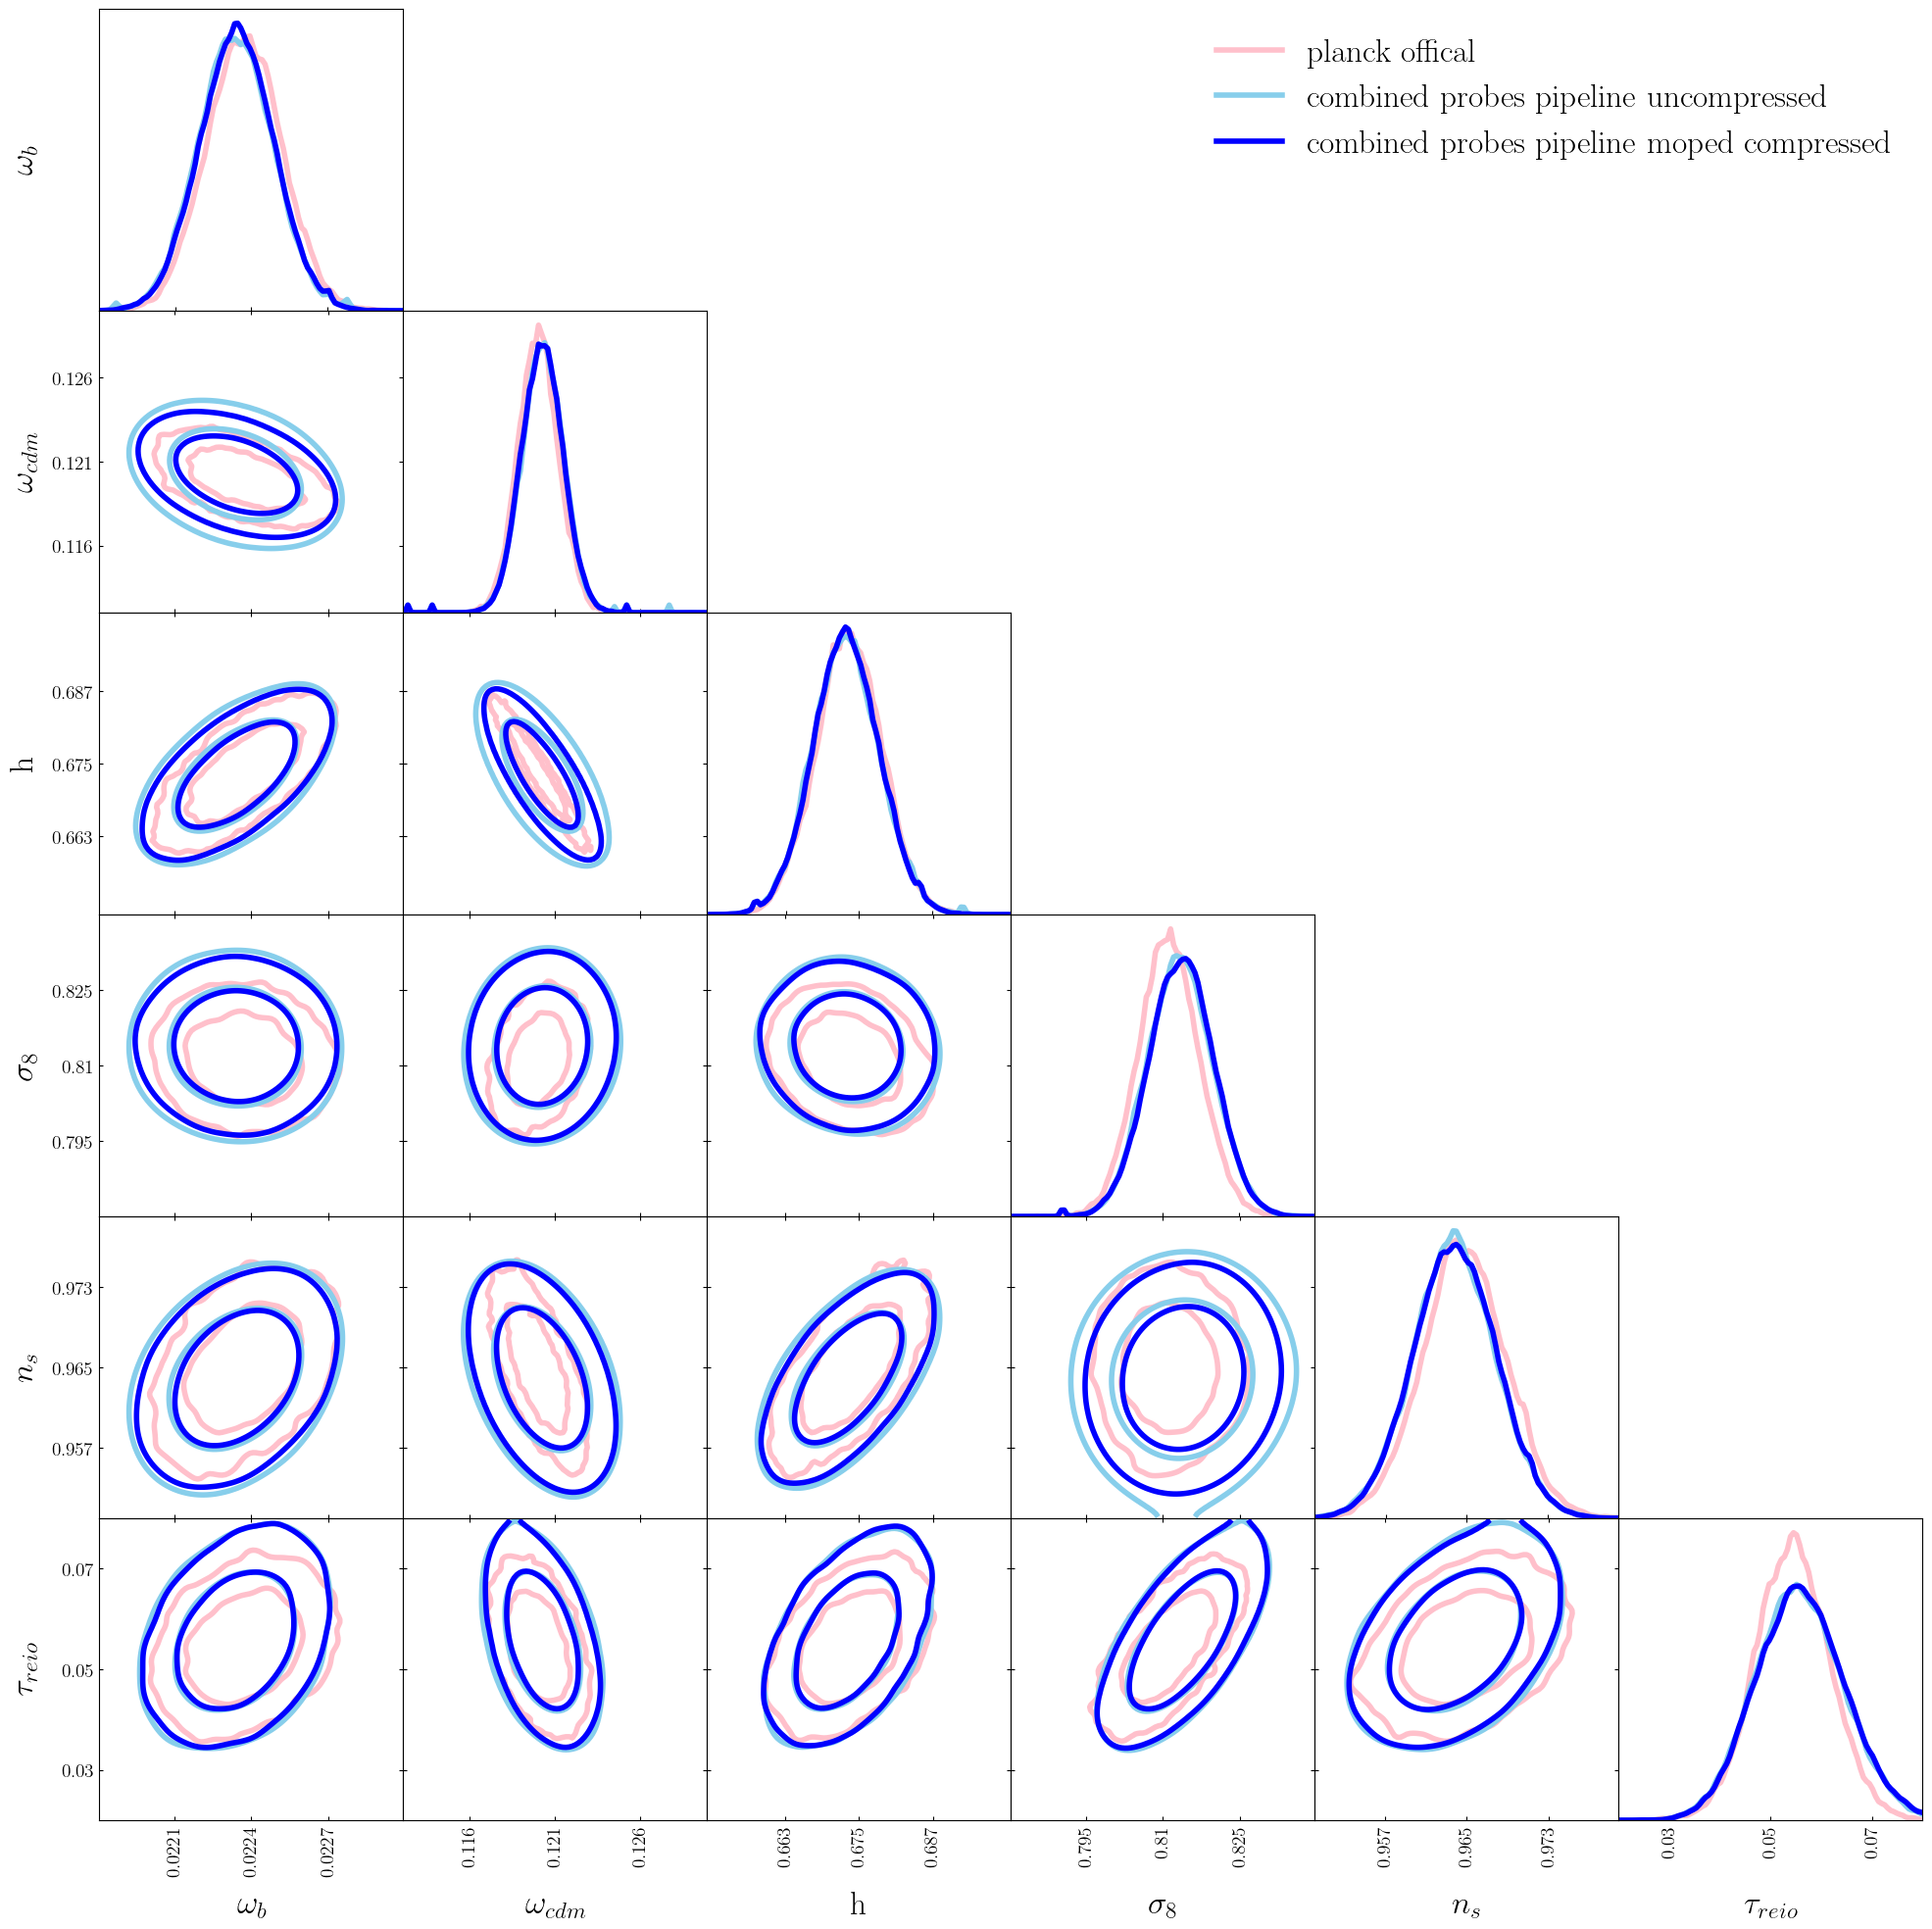

In [18]:
tri = TriangleChain(density_estimation_method='smoothing', params=params, ranges=ranges, labels=[r"$\omega_b$", r"$\omega_{cdm}$", r"h", r"$\sigma_8$", r"$n_s$", r"$\tau_{reio}$"])
tri.contour_cl(planck_official, color='pink', label="planck offical")
tri.contour_cl(params_chain_burned_in,color='skyblue', label="combined probes pipeline uncompressed")
tri.contour_cl(params_chain_moped_burned_in,color='blue', alpha=0.5,label="combined probes pipeline moped compressed", show_legend=True)